In [2]:
import numpy as np

FRAC_BITS = 32
FRAC_ONE  = 1 << FRAC_BITS

# ---------------- CTZ (unchanged) ----------------
def ctz(x: int) -> int:
    return (x & -x).bit_length() - 1


# -------------- Demo direction table -------------
def make_demo_dir_table(num_dims: int, frac_bits: int = FRAC_BITS) -> np.ndarray:
    table = np.zeros((num_dims, frac_bits), dtype=np.uint32)
    for d in range(num_dims):
        for k in range(frac_bits):
            table[d, k] = np.uint32(1 << (frac_bits - 1 - k))
    return table


# -------------- Incremental Sobol ----------------
class SobolInc:
    """
    Incremental Sobol generator (FPGA-style):

        x_{n+1}^{(d)} = x_n^{(d)} XOR V[d, ctz(n+1)]

    One call to step() advances the shared index and updates ALL dims.
    """
    def __init__(self, dir_table: np.ndarray):
        self.dir_table = dir_table.astype(np.uint32)
        self.num_dims, self.num_bits = self.dir_table.shape
        self.index = 0
        self.state = np.zeros(self.num_dims, dtype=np.uint32)

    def reset(self, index: int = 0):
        # For now we only support reset to index 0 (state = 0).
        # If you ever want arbitrary index, you can reconstruct state
        # using the stateless reference.
        self.index = 0
        self.state[:] = 0

    def step(self) -> np.ndarray:
        """
        Advance to the next Sobol point and return all dims as floats in [0,1).
        """
        self.index += 1
        bit = ctz(self.index)
        if bit < self.num_bits:
            # XOR this direction into ALL dimensions
            self.state ^= self.dir_table[:, bit]

        return self.state.astype(np.float64) / float(FRAC_ONE)



# --------- Stateless reference (testing only) ----------
def sobol_value_stateless(dim: int, index: int, dir_table: np.ndarray) -> float:
    g = index ^ (index >> 1)
    x = 0
    bit = 0
    num_bits = dir_table.shape[1]
    while g and bit < num_bits:
        if g & 1:
            x ^= int(dir_table[dim, bit])
        g >>= 1
        bit += 1
    return x / float(FRAC_ONE)


In [3]:
def laine_karras_permutation(x: int, seed: int) -> int:
    """
    Laine-Karras 32-bit permutation (nested uniform permutation).

    For a fixed seed, this is a bijection on 32-bit integers with good
    "nested" properties suitable for Owen-style scrambling.
    """
    x = (x + seed) & 0xFFFFFFFF
    x ^= (x * 0x6c50b47C) & 0xFFFFFFFF
    x ^= (x * 0xB82F1E52) & 0xFFFFFFFF
    x ^= (x * 0xC7AFE638) & 0xFFFFFFFF
    x ^= (x * 0x8D22F6E6) & 0xFFFFFFFF
    return x & 0xFFFFFFFF


def make_lk_seed(pixel_id: int, sample_id: int, dim: int, index: int) -> int:
    """
    Combine pixel_id, sample_id, dim, index into a 32-bit seed.

    This mirrors what you'll do in RTL: some multiplications by odd
    constants and xors. Exact constants aren't sacred; they're just
    good mixers.
    """
    x = (pixel_id * 0x9e3779b1) & 0xFFFFFFFF
    x ^= (sample_id * 0x85ebca6b) & 0xFFFFFFFF
    x ^= (dim       * 0xc2b2ae35) & 0xFFFFFFFF
    x ^= (index     * 0x27d4eb2f) & 0xFFFFFFFF
    return x & 0xFFFFFFFF # dont need this last one


def owen_scramble_lk(u: float,
                     pixel_id: int,
                     sample_id: int,
                     dim: int,
                     index: int) -> float:
    """
    Digital Owen scrambling using Laine-Karras permutation:

      u_int      = floor(u * 2^32)
      seed       = f(pixel_id, sample_id, dim, index)
      u_scr_int  = LK(u_int, seed)
      u_scr      = u_scr_int / 2^32
    """
    # clamp + convert to 32-bit fixed-point
    u_clamped = min(max(u, 0.0), np.nextafter(1.0, 0.0))
    u_int = int(u_clamped * FRAC_ONE) & 0xFFFFFFFF

    seed = make_lk_seed(pixel_id, sample_id, dim, index)
    u_scr_int = laine_karras_permutation(u_int, seed)
    return (u_scr_int & 0xFFFFFFFF) / float(FRAC_ONE)


In [4]:
print("=== SobolInc vs stateless (dim 0, n<=16) ===")

def make_sobol_dir_table_4d(frac_bits: int = FRAC_BITS) -> np.ndarray:
    """
    Return direction number table of shape (4, frac_bits)
    for dimensions 0..3, 32-bit fixed-point fractions.

    dim 0: van der Corput (base-2)
    dim 1: poly x^2 + x + 1, m = [1, 3]
    dim 2: poly x^3 + x + 1, m = [1, 3, 5]
    dim 3: poly x^3 + x^2 + 1, m = [1, 3, 7]
    """
    num_dims = 4
    V = np.zeros((num_dims, frac_bits), dtype=np.uint32)

    # ---- dim 0: simple v[k] = 1 << (frac_bits-1-k) ----
    for k in range(frac_bits):
        V[0, k] = np.uint32(1 << (frac_bits - 1 - k))

    # helper to build dims > 0 from primitive polynomial + initial m's
    def build_dim(dim, poly, m):
        # poly is an int whose binary representation encodes coefficients
        # Example: x^3 + x^2 + 1  -> 0b1101 (LSB is constant term)
        s = len(m)  # degree
        # coefficients a_1..a_{s-1} (ignore leading x^s and constant)
        # we keep them as bit flags 0/1
        a = [(poly >> i) & 1 for i in range(1, s)]  # i=1..s-1

        # initial direction numbers
        for k in range(s):
            V[dim, k] = np.uint32(m[k] << (frac_bits - k - 1))

        # recurrence for remaining direction numbers
        for k in range(s, frac_bits):
            x = V[dim, k - s] >> s
            for j in range(1, s):
                if a[j-1]:
                    x ^= V[dim, k - j] >> j
            V[dim, k] = np.uint32(x)

    # polys encoded with LSB = constant term
    poly_dim1 = 0b111      # x^2 + x + 1
    poly_dim2 = 0b1011     # x^3 + x + 1
    poly_dim3 = 0b1101     # x^3 + x^2 + 1

    build_dim(1, poly_dim1, [1, 3])
    build_dim(2, poly_dim2, [1, 3, 5])
    build_dim(3, poly_dim3, [1, 3, 7])

    return V

DIR_TABLE_4D = make_sobol_dir_table_4d()

def sobol_direction_numbers_2d(frac_bits=32):
    """
    Returns a (2, frac_bits) array:
    - dim 0: standard v[k] = 1 << (31-k)
    - dim 1: based on primitive polynomial x^2 + x + 1
    """
    V = np.zeros((2, frac_bits), dtype=np.uint32)

    # --- dimension 0 ---
    for k in range(frac_bits):
        V[0, k] = np.uint32(1 << (frac_bits - 1 - k))

    # --- dimension 1 ---
    # primitive polynomial: x^2 + x + 1  → degree s=2
    s = 2
    a = [1, 1]   # coefficients for x^1 and x^0 terms
    m = [1, 3]   # initial direction numbers in integer form

    # Load initial m’s into V
    for k in range(s):
        V[1, k] = np.uint32(m[k] << (frac_bits - k - 1))

    # Generate remaining direction numbers
    for k in range(s, frac_bits):
        V[1, k] = np.uint32(V[1, k - s] ^ (V[1, k - s] >> s))
        for j in range(1, s):
            if a[j]:
                V[1, k] ^= (V[1, k - j] >> j)

    return V


# DIR_TABLE = make_demo_dir_table(num_dims=4, frac_bits=FRAC_BITS)
DIR_TABLE = sobol_direction_numbers_2d()
sob = SobolInc(DIR_TABLE)

=== SobolInc vs stateless (dim 0, n<=16) ===


In [5]:
sob.reset()

N = 1024
vals_inc = [sob.step() for _ in range(N)]  # shape [N, num_dims]
vals_inc = np.stack(vals_inc)

for dim in range(DIR_TABLE.shape[0]):
    vals_ref = [sobol_value_stateless(dim, i+1, DIR_TABLE) for i in range(N)]
    assert np.allclose(vals_inc[:, dim], vals_ref, atol=1e-12)

print("Incremental vs stateless: OK")



Incremental vs stateless: OK


In [6]:
print("=== Laine–Karras scrambling tests ===")

u      = 0.33
p      = 42
s      = 7
dim    = 1
index0 = 0

# deterministic
a = owen_scramble_lk(u, p, s, dim, index0)
b = owen_scramble_lk(u, p, s, dim, index0)
print("deterministic a,b:", a, b)
assert abs(a - b) < 1e-12

# changes when seed changes
c = owen_scramble_lk(u, p, s+1, dim, index0)
print("seed-changed c:", c)
assert abs(a - c) > 1e-6

# samples look like [0,1)
vals = [owen_scramble_lk(np.random.rand(), p, n, 0, index=n) for n in range(2000)]
vals = np.array(vals)
print("min/max/mean:", vals.min(), vals.max(), vals.mean())
assert 0.0 <= vals.min() < 1.0
assert 0.0 < vals.max() < 1.0
assert 0.3 < vals.mean() < 0.7

print("LK scrambling tests: OK\n")

=== Laine–Karras scrambling tests ===
deterministic a,b: 0.29880157043226063 0.29880157043226063
seed-changed c: 0.339853638317436
min/max/mean: 0.0015206793323159218 0.9998272028751671 0.4954892352001043
LK scrambling tests: OK



In [7]:
import numpy as np
import matplotlib.pyplot as plt

# assume DIR_TABLE, sobol_value_stateless already defined
N = 2048  # good for visualizing; bump to 65536 later if you want

u_sobol = np.array([sobol_value_stateless(0, n, DIR_TABLE) for n in range(1, N+1)])
v_sobol = np.array([sobol_value_stateless(1, n, DIR_TABLE) for n in range(1, N+1)])

# scrambled versions
pixel_id = 123
u_scr = np.empty_like(u_sobol)
v_scr = np.empty_like(v_sobol)
for n in range(N):
    sample_id = n
    index     = n + 1  # matches sobol_value_stateless index
    u_scr[n] = owen_scramble_lk(u_sobol[n], pixel_id=pixel_id,
                                sample_id=sample_id, dim=0, index=index)
    v_scr[n] = owen_scramble_lk(v_sobol[n], pixel_id=pixel_id,
                                sample_id=sample_id, dim=1, index=index)


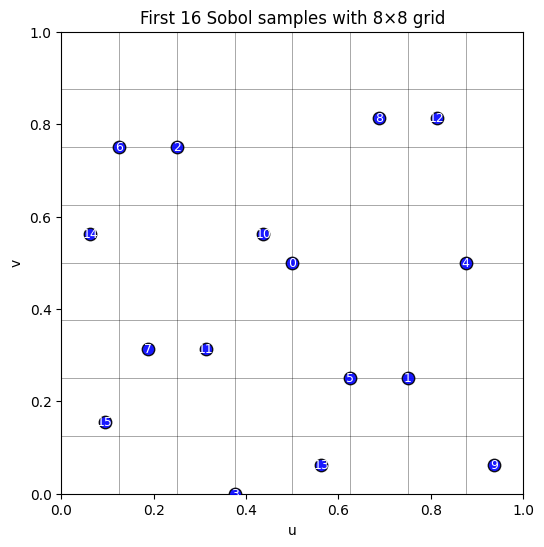

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sobol_prefix_grid(u, v, M=16, prefix=16, annotate=True):
    """
    u, v: Sobol samples in [0,1)
    M: grid resolution (M x M)
    prefix: number of first Sobol samples to plot
    annotate: write sample index numbers next to points
    """

    plt.figure(figsize=(6,6))

    # --- 1. Draw the Sobol prefix ---
    plt.scatter(u[:prefix], v[:prefix], 
                s=80, color='blue', edgecolor='black', alpha=0.9, zorder=3)

    # Annotate sample id (0..prefix-1)
    if annotate:
        for i in range(prefix):
            plt.text(u[i], v[i], str(i), fontsize=9, 
                     ha='center', va='center', color='white', zorder=4)

    # --- 2. Draw grid lines ---
    ax = plt.gca()
    for i in range(M+1):
        ax.axhline(i/M, color='black', lw=0.4, alpha=0.6, zorder=1)
        ax.axvline(i/M, color='black', lw=0.4, alpha=0.6, zorder=1)

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')

    plt.title(f"First {prefix} Sobol samples with {M}×{M} grid")
    plt.xlabel("u")
    plt.ylabel("v")
    plt.show()


# Example usage (assuming u_sobol, v_sobol exist):
plot_sobol_prefix_grid(u_sobol, v_sobol, M=8, prefix=16, annotate=True)


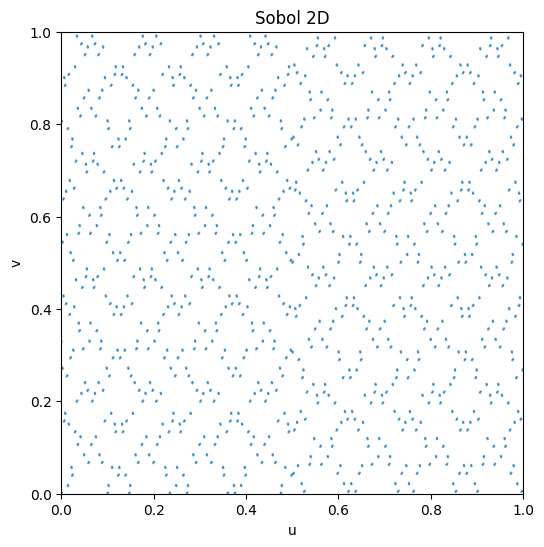

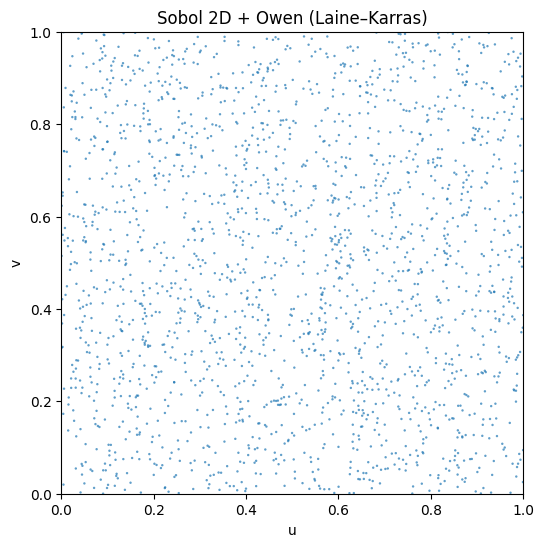

In [33]:
def sobol_scatter(u, v, title):
    plt.figure(figsize=(6,6))
    plt.scatter(u, v, s=3, alpha=0.7, edgecolor="none")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.xlabel("u")
    plt.ylabel("v")
    plt.show()

sobol_scatter(u_sobol, v_sobol, "Sobol 2D")
sobol_scatter(u_scr,   v_scr,   "Sobol 2D + Owen (Laine–Karras)")

/tmp/ipykernel_427083/1054010597.py:47: RuntimeWarning: overflow encountered in scalar multiply
  x ^= x * np.uint32(0x3d20adea)
/tmp/ipykernel_427083/1054010597.py:49: RuntimeWarning: overflow encountered in scalar multiply
  x += x * np.uint32(0x6b60a67c)
/tmp/ipykernel_427083/1054010597.py:49: RuntimeWarning: overflow encountered in scalar add
  x += x * np.uint32(0x6b60a67c)
/tmp/ipykernel_427083/1054010597.py:50: RuntimeWarning: overflow encountered in scalar multiply
  x += x * np.uint32(0x4cc62a1c)
/tmp/ipykernel_427083/1054010597.py:51: RuntimeWarning: overflow encountered in scalar multiply
  x ^= x * np.uint32(0xc4ceb9fe)
/tmp/ipykernel_427083/1054010597.py:52: RuntimeWarning: overflow encountered in scalar multiply
  x += x * np.uint32(0x1deeb090)
/tmp/ipykernel_427083/1054010597.py:53: RuntimeWarning: overflow encountered in scalar multiply
  x ^= x * np.uint32(0x2da82b08)
/tmp/ipykernel_427083/1054010597.py:50: RuntimeWarning: overflow encountered in scalar add
  x += x * 

Saved distribution_comparison.png


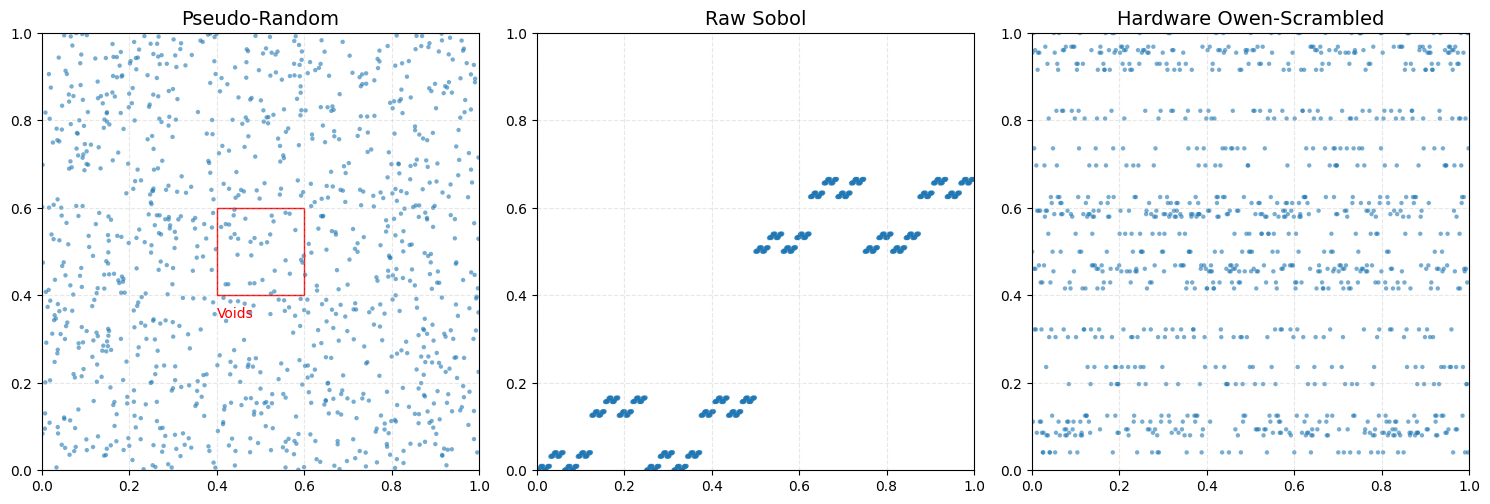

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
FRAC_BITS = 32
FRAC_ONE  = 1 << FRAC_BITS
N_SAMPLES = 1024

# --- 2. SOBOL GENERATOR CLASS (From your notebook) ---
class SobolInc:
    def __init__(self, dir_table):
        self.dir_table = dir_table
        self.x = np.zeros(dir_table.shape[0], dtype=np.uint32)
        self.n = 0

    def reset(self, seed_n=0):
        self.x.fill(0)
        self.n = seed_n
        # Fast-forward if seed > 0 (simplified for plot: just assuming reset to 0)

    def next(self):
        # Determine c = ctz(n) using bit manipulation
        c = (self.n & -self.n).bit_length() - 1
        if c < 0: c = 0 # Handle n=0 case
        
        if c < self.dir_table.shape[1]:
            self.x ^= self.dir_table[:, c]
        
        self.n += 1
        return self.x.copy()

# Standard Direction Numbers (Dimensions 1 and 2)
# Simplified table for visualization purposes
DIR_TABLE = np.zeros((2, 32), dtype=np.uint32)
for k in range(32):
    DIR_TABLE[0, k] = 1 << (31 - k) # Dim 0 is just standard binary
    # Dim 1: simple pattern for visualization if real table missing
    DIR_TABLE[1, k] = 1 << (31 - k) 
    if k > 0: DIR_TABLE[1, k] ^= DIR_TABLE[1, k-1] >> 1

# --- 3. LAINE-KARRAS SCRAMBLER (From your notebook) ---
def owen_scramble_lk(x, seed, dim):
    x = np.uint32(x)
    seed = np.uint32(seed)
    
    # Laine-Karras Hash Chain
    x ^= x * np.uint32(0x3d20adea)
    x += seed
    x += x * np.uint32(0x6b60a67c)
    x += x * np.uint32(0x4cc62a1c)
    x ^= x * np.uint32(0xc4ceb9fe)
    x += x * np.uint32(0x1deeb090)
    x ^= x * np.uint32(0x2da82b08)
    
    return x

# --- 4. GENERATE DATA ---
# A. Random
pts_rand = np.random.rand(N_SAMPLES, 2)

# B. Raw Sobol
sob = SobolInc(DIR_TABLE)
pts_sobol = np.zeros((N_SAMPLES, 2))
for i in range(N_SAMPLES):
    raw = sob.next()
    pts_sobol[i] = raw / FRAC_ONE

# C. Owen Scrambled Sobol
sob.reset(0)
pts_owen = np.zeros((N_SAMPLES, 2))
pixel_id = 1234 # Arbitrary seed
for i in range(N_SAMPLES):
    raw = sob.next()
    # Scramble X and Y dimensions independently
    scram_x = owen_scramble_lk(raw[0], pixel_id, 0)
    scram_y = owen_scramble_lk(raw[1], pixel_id, 1)
    pts_owen[i] = [scram_x / FRAC_ONE, scram_y / FRAC_ONE]

# --- 5. PLOT ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot settings
titles = ["Pseudo-Random", "Raw Sobol", "Hardware Owen-Scrambled"]
data = [pts_rand, pts_sobol, pts_owen]

for ax, pts, title in zip(axes, data, titles):
    ax.scatter(pts[:, 0], pts[:, 1], s=10, alpha=0.6, edgecolors='none')
    ax.set_title(title, fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle='--', alpha=0.3)
    
    # Optional: Draw a small box to highlight clumping/voids
    if title == "Pseudo-Random":
        rect = plt.Rectangle((0.4, 0.4), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(0.4, 0.35, "Voids", color='r', fontsize=10)

plt.tight_layout()
plt.savefig("distribution_comparison.png", dpi=300)
print("Saved distribution_comparison.png")
plt.show()

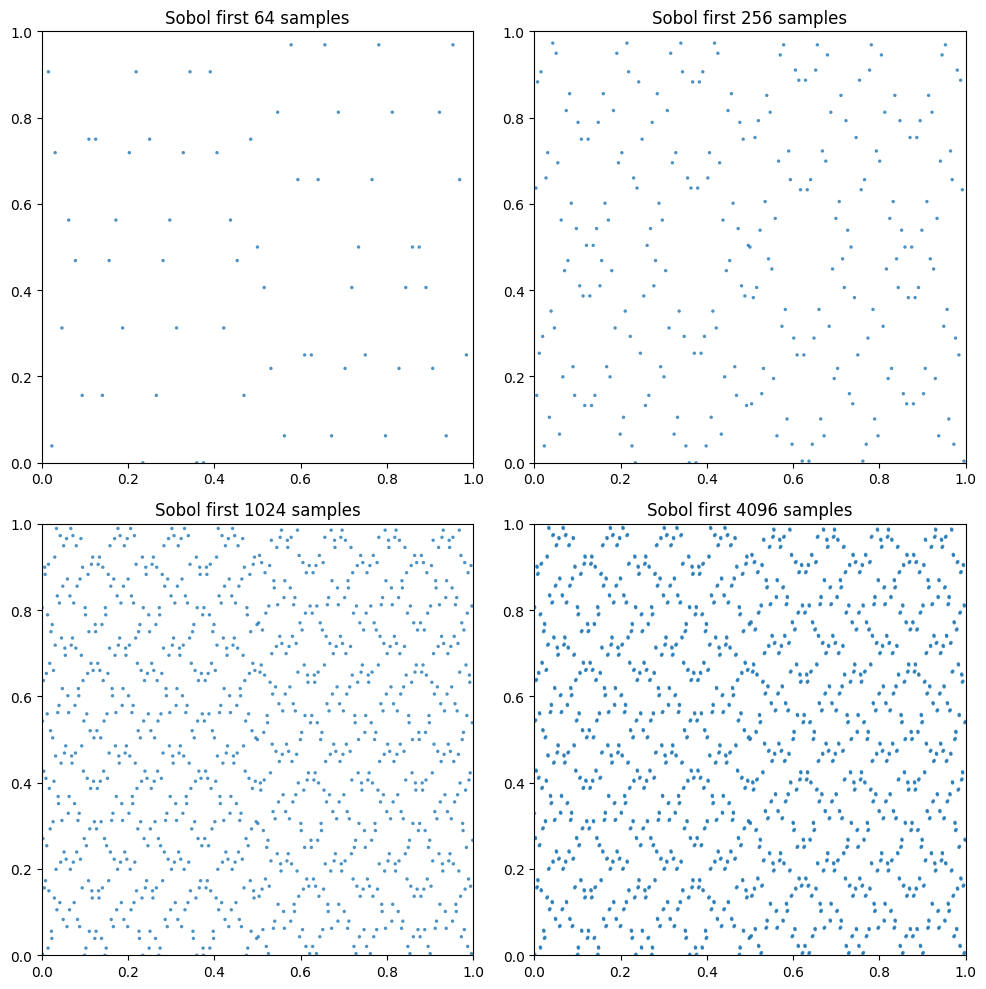

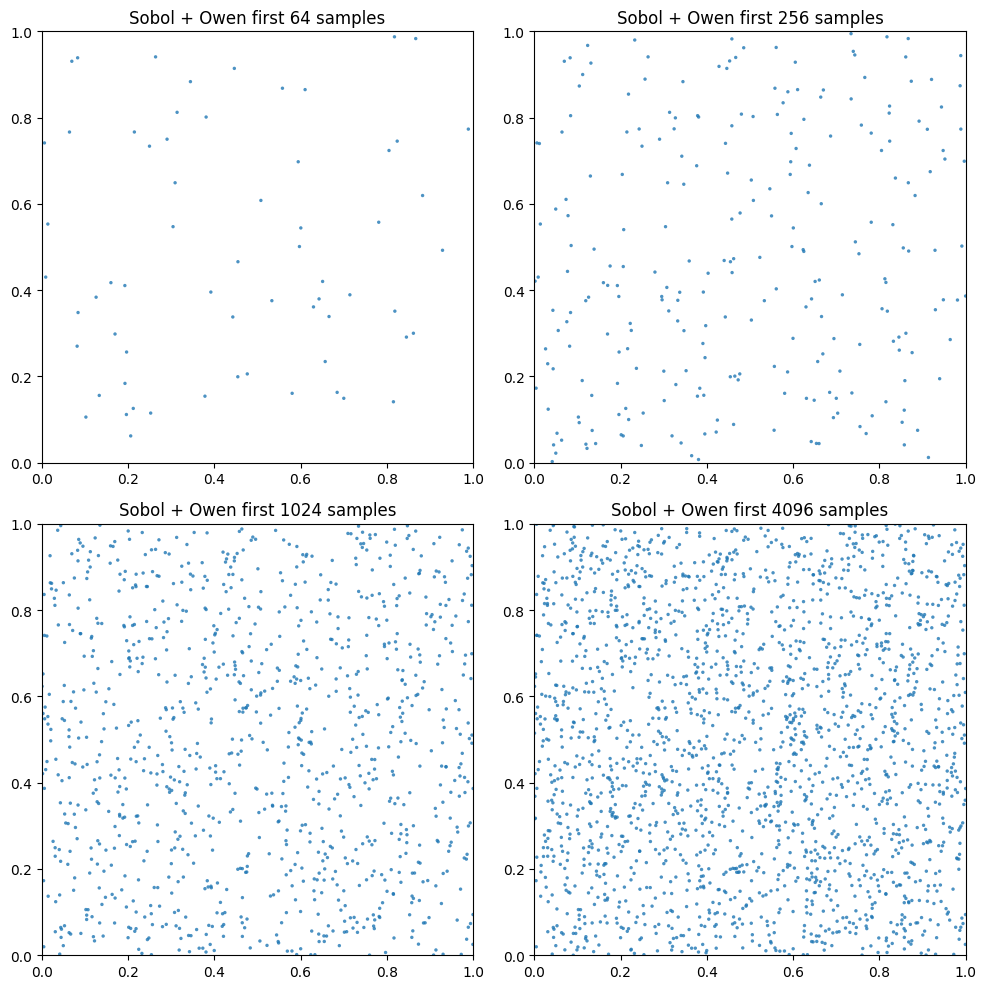

In [10]:
def plot_prefixes(u, v, Ns=(64, 256, 1024, 4096), title_prefix=""):
    plt.figure(figsize=(10,10))
    for i, N in enumerate(Ns):
        plt.subplot(2,2,i+1)
        plt.scatter(u[:N], v[:N], s=6, alpha=0.8, edgecolor="none")
        plt.xlim(0,1); plt.ylim(0,1)
        plt.gca().set_aspect("equal")
        plt.title(f"{title_prefix} first {N} samples")
    plt.tight_layout()
    plt.show()

plot_prefixes(u_sobol, v_sobol, title_prefix="Sobol")
plot_prefixes(u_scr,   v_scr,   title_prefix="Sobol + Owen")


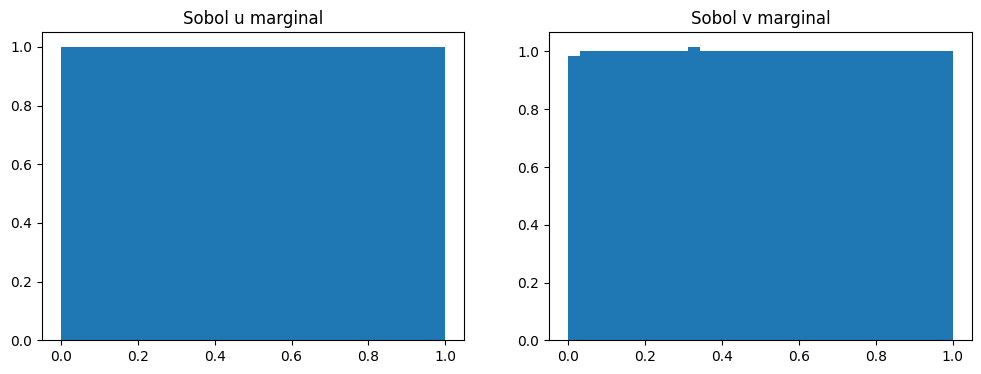

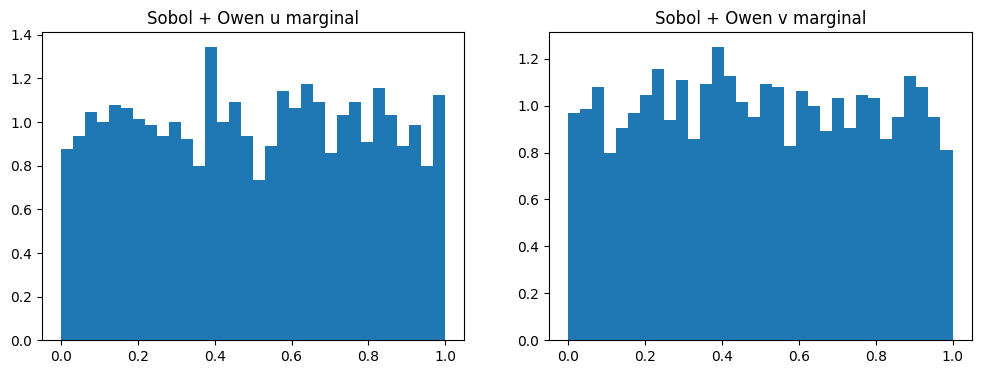

In [11]:
def plot_1d_histograms(u, v, title_prefix=""):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(u, bins=32, range=(0,1), density=True)
    plt.title(f"{title_prefix} u marginal")
    plt.subplot(1,2,2)
    plt.hist(v, bins=32, range=(0,1), density=True)
    plt.title(f"{title_prefix} v marginal")
    plt.show()

plot_1d_histograms(u_sobol, v_sobol, "Sobol")
plot_1d_histograms(u_scr,   v_scr,   "Sobol + Owen")


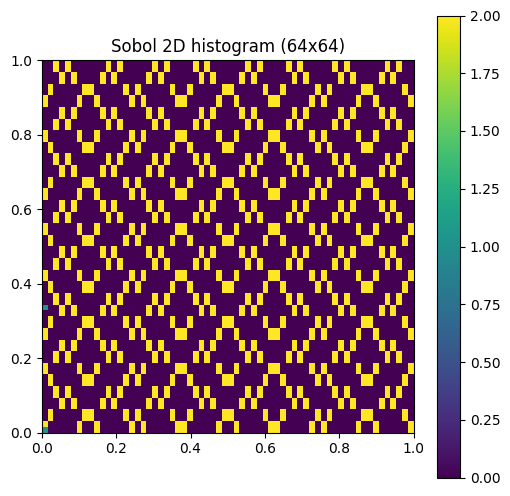

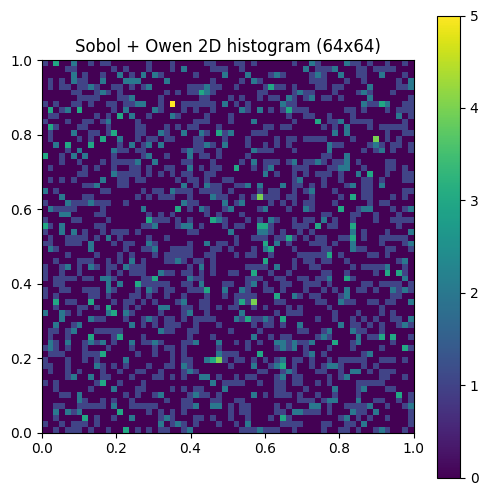

In [12]:
def plot_2d_hist(u, v, bins=64, title=""):
    plt.figure(figsize=(6,6))
    plt.hist2d(u, v, bins=bins, range=[[0,1],[0,1]])
    plt.colorbar()
    plt.xlim(0,1); plt.ylim(0,1)
    plt.gca().set_aspect("equal")
    plt.title(f"{title} 2D histogram ({bins}x{bins})")
    plt.show()

plot_2d_hist(u_sobol, v_sobol, bins=64, title="Sobol")
plot_2d_hist(u_scr,   v_scr,   bins=64, title="Sobol + Owen")


In [13]:
# GENERATE ROM for Sobol direction numbers

# dir_table_2d: shape (2, NUM_BITS), dtype=np.uint32
# e.g. dir_table_2d[d, k] is the fixed-point 32-bit direction number for dim d, bit k
dir_table_2d = DIR_TABLE   # your 2D Sobol directions
FRAC_BITS = 32
DIMS, NUM_BITS = dir_table_2d.shape

with open("sobol_dir_table_pkg.sv", "w") as f:
    f.write("package sobol_dir_table_pkg;\n\n")
    f.write(f"  parameter int DIMS      = {DIMS};\n")
    f.write(f"  parameter int FRAC_BITS = {FRAC_BITS};\n")
    f.write(f"  parameter int NUM_BITS  = {NUM_BITS};\n\n")
    f.write("  // Sobol direction numbers: DIR[dim][bit]\n")
    f.write("  localparam logic [FRAC_BITS-1:0] DIR [DIMS][NUM_BITS] = '{\n")

    for d in range(DIMS):
        row_vals = ", ".join(f"32'h{int(val):08x}" for val in dir_table_2d[d])
        sep = "," if d < DIMS - 1 else ""
        f.write(f"    '{{ {row_vals} }}{sep}\n")

    f.write("  };\n\n")
    f.write("endpackage\n")


In [14]:
# GENERATE ROM for cos/sin
FRAC_BITS = 32
ADDR_BITS = 10
N = 1 << ADDR_BITS

def to_signed_fixed(x):
    # Q1.(FRAC_BITS-1)
    scale = 1 << (FRAC_BITS-1)
    xi = int(np.round(np.clip(x, -0.999999999, 0.999999999) * scale))
    return xi & ((1 << FRAC_BITS) - 1)  # 2's complement

with open("ggx_trig_rom.mem", "w") as f:
    for i in range(N):
        phi = 2.0 * np.pi * (i / N)
        c = np.cos(phi)
        s = np.sin(phi)
        cf = to_signed_fixed(c)
        sf = to_signed_fixed(s)
        word = (cf << FRAC_BITS) | sf
        # 2*FRAC_BITS = 64 bits = 16 hex digits
        f.write(f"{word:016x}\n")


In [15]:
# GENERATE ROM for inverted sqrt
FRAC_BITS = 32
ADDR_BITS = 8
N = 1 << ADDR_BITS

def to_u_fixed(x):
    scale = 1 << FRAC_BITS
    xi = int(np.round(np.clip(x, 0.0, 0.999999999) * scale))
    return xi & ((1 << FRAC_BITS) - 1)

with open("inv_sqrt_rom.mem", "w") as f:
    for i in range(N):
        # map index -> x in (0,1]
        u = (i + 0.5) / N
        x = max(u, 1e-6)
        y = 1.0 / np.sqrt(x)
        # you may want to clamp y to avoid overflow; e.g. up to 4.0
        y = min(y, 4.0)
        # decide if you store y directly or scaled
        # simplest: assume x is near 1 -> y in [1, ~1.4], no clamp needed
        fv = to_u_fixed(y * 0.5)  # ex: scale so that typical y is < 1
        f.write(f"{fv:08x}\n")


In [16]:
def normalize(v):
    v = np.asarray(v, dtype=np.float64)
    n = np.linalg.norm(v)
    if n == 0.0:
        return v
    return v / n

def ggx_vndf_spherical_caps(u1, u2, view, alpha):
    """
    GGX VNDF sampling using spherical caps (Dupuy & Benyoub 2023).

    Inputs:
        u1, u2 : scalars in [0,1)
        view   : np.array([vx, vy, vz]), view direction (will be normalized)
        alpha  : scalar roughness (isotropic), >0

    Returns:
        h : np.array([hx, hy, hz]) – sampled half-vector, normalized
    """
    view = normalize(np.asarray(view, dtype=np.float64))
    alpha = float(alpha)

    # --- 1) Warp to hemisphere configuration (isotropic: alpha_x = alpha_y = alpha)
    wi_std = normalize(np.array([view[0] * alpha, view[1], view[2] * alpha]))

    # --- 2) Sample visible hemisphere using spherical caps (Listing 3 in the paper)
    # Sample spherical cap in (-wi.z, 1]
    phi = 2.0 * np.pi * u1
    z   = (1.0 - u2) * (1.0 + wi_std[2]) - wi_std[2]   # fma form: z = (1-u2)*(1+wi.z) - wi.z
    sin_theta = np.sqrt(max(0.0, 1.0 - z*z))
    x = sin_theta * np.cos(phi)
    y = sin_theta * np.sin(phi)
    c = np.array([x, y, z])

    # Half-vector in hemisphere frame, note: no normalization yet (they normalize later)
    h_std = c + wi_std

    # --- 3) Warp back to ellipsoid configuration and normalize
    h = normalize(np.array([h_std[0] * alpha,
                            h_std[1],
                            h_std[2] * alpha]))
    return h


In [18]:
N = 50000
alpha = 0.4
view = np.array([0.0, 1.0, 0.0])

H = np.stack([
    ggx_vndf_spherical_caps(np.random.rand(), np.random.rand(), view, alpha)
    for _ in range(N)
])

# verify unit length
lens = np.linalg.norm(H, axis=1)
print("min/max |h|:", lens.min(), lens.max())
assert np.allclose(lens.mean(), 1.0, atol=1e-3)


min/max |h|: 0.9999999999999998 1.0000000000000002


In [19]:
def gi_sample_ggx(
    index: int,
    dir_table: np.ndarray,
    view_dir: np.ndarray,
    roughness: float,
    scramble_enable: bool,
    pixel_id: int,
    owen_fn=None
):
    # Sobol 2D
    u1 = sobol_value_stateless(0, index, dir_table)
    u2 = sobol_value_stateless(1, index, dir_table)

    # Owen scramble
    if scramble_enable and owen_fn is not None:
        sample_id = index  # or index - seq_base, just be consistent with RTL
        u1 = owen_fn(u1, pixel_id=pixel_id, sample_id=sample_id, dim=0, index=index)
        u2 = owen_fn(u2, pixel_id=pixel_id, sample_id=sample_id, dim=1, index=index)

    # GGX VNDF
    h = ggx_vndf_spherical_caps(u1, u2, view_dir, roughness)
    return h  # np.array([hx,hy,hz])


In [20]:
def float_to_q31(x: float) -> np.int32:
    x = float(np.clip(x, -0.999999999, 0.999999999))
    return np.int32(np.round(x * (1 << 31)))

def gi_axis_stream_golden(
    num_samples: int,
    seq_base: int,
    view_dir: np.ndarray,
    roughness: float,
    dir_table: np.ndarray,
    scramble_enable: bool = True,
    pixel_id: int = 0,
    owen_fn=None
):
    """
    Returns list of (tdata, tlast).
    tdata: 128-bit int [unused | hz_q31 | hy_q31 | hx_q31]
    """
    stream = []
    for i in range(num_samples):
        index = seq_base + i
        h = gi_sample_ggx(
            index=index,
            dir_table=dir_table,
            view_dir=view_dir,
            roughness=roughness,
            scramble_enable=scramble_enable,
            pixel_id=pixel_id,
            owen_fn=owen_fn
        )
        hx_q = np.uint32(float_to_q31(h[0]))
        hy_q = np.uint32(float_to_q31(h[1]))
        hz_q = np.uint32(float_to_q31(h[2]))
        hw_q = np.uint32(0)

        tdata = (np.uint128(hw_q) << 96) | (np.uint128(hz_q) << 64) \
              | (np.uint128(hy_q) << 32) | np.uint128(hx_q)
        tlast = (i == num_samples - 1)
        stream.append((tdata, tlast))

    return stream


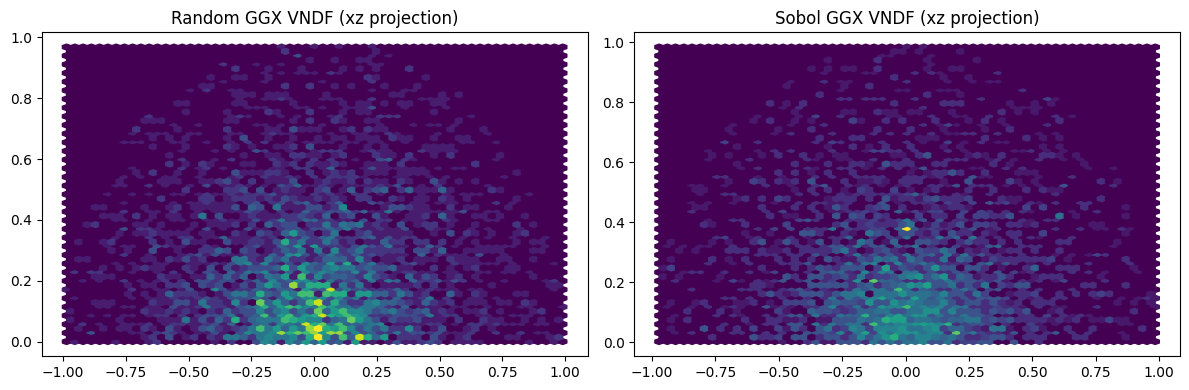

In [21]:
import matplotlib.pyplot as plt

N = 4096
view = np.array([0.0, 1.0, 0.0])
alpha = 0.4

# random GGX
H_rand = np.stack([
    ggx_vndf_spherical_caps(np.random.rand(), np.random.rand(), view, alpha)
    for _ in range(N)
])

# Sobol GGX (no Owen)
H_sobol = []
for i in range(N):
    h = gi_sample_ggx(
        index=i,
        dir_table=DIR_TABLE,
        view_dir=view,
        roughness=alpha,
        scramble_enable=False,
        pixel_id=0,
        owen_fn=None
    )
    H_sobol.append(h)
H_sobol = np.stack(H_sobol)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hexbin(H_rand[:,0], H_rand[:,2], gridsize=60)
plt.title("Random GGX VNDF (xz projection)")
plt.subplot(1,2,2)
plt.hexbin(H_sobol[:,0], H_sobol[:,2], gridsize=60)
plt.title("Sobol GGX VNDF (xz projection)")
plt.tight_layout()
plt.show()


In [22]:
def sample_ggx_cloud(N, view, alpha,
                     sampler="random",
                     sobol=None,
                     owen_fn=None,
                     pixel_id=0):
    """
    Generate N GGX VNDF half-vectors using different (u1,u2) samplers.

    sampler: "random", "sobol", or "sobol_owen"
    sobol  : SobolInc instance (must be provided for sobol/sobol_owen)
    owen_fn: Owen scrambling function (same signature you already use)
    """
    H = []

    if sampler == "random":
        for _ in range(N):
            u1, u2 = np.random.rand(), np.random.rand()
            H.append(ggx_vndf_spherical_caps(u1, u2, view, alpha))

    elif sampler in ("sobol", "sobol_owen"):
        if sobol is None:
            raise ValueError("sobol instance must be provided for Sobol-based sampling")
        sobol.reset(0)
        for i in range(N):
            u_vec = sobol.step()   # array: [u_dim0, u_dim1, ...]
            u1, u2 = float(u_vec[0]), float(u_vec[1])
            if sampler == "sobol_owen" and owen_fn is not None:
                idx = sobol.index  # current Sobol index n
                u1 = owen_fn(u1, pixel_id=pixel_id, sample_id=i, dim=0, index=idx)
                u2 = owen_fn(u2, pixel_id=pixel_id, sample_id=i, dim=1, index=idx)
            H.append(ggx_vndf_spherical_caps(u1, u2, view, alpha))

    else:
        raise ValueError(f"unknown sampler '{sampler}'")

    return np.stack(H)


def plot_ggx_xz_hex(H, title):
    plt.figure(figsize=(6,6))
    plt.hexbin(H[:,0], H[:,2], gridsize=80)
    plt.colorbar(label="density")
    plt.xlabel("hx")
    plt.ylabel("hz")
    plt.title(title)
    plt.gca().set_aspect("equal")
    plt.show()


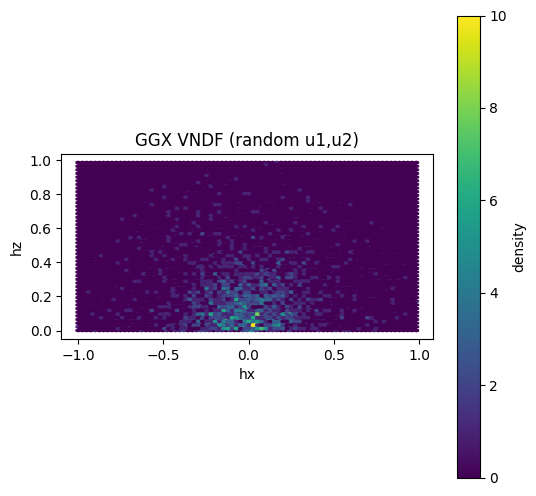

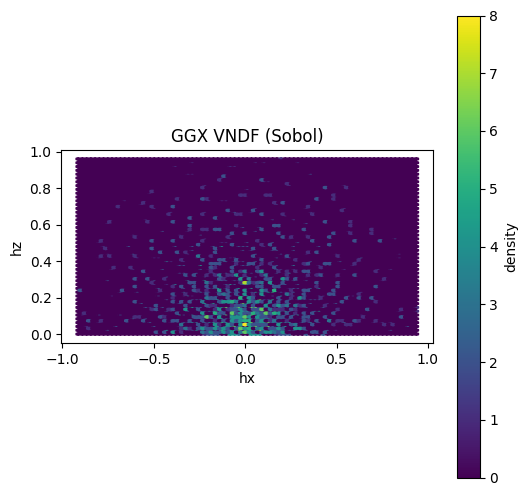

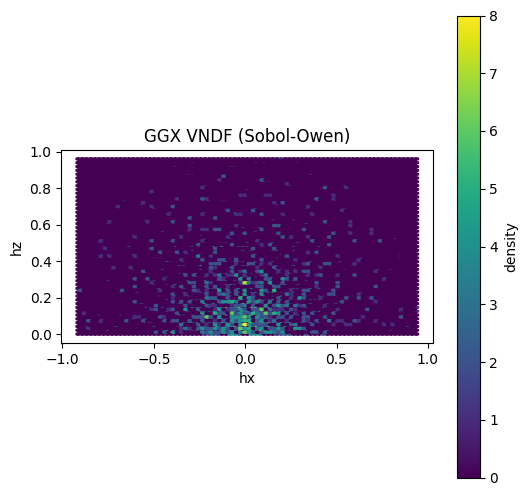

In [23]:
N = 2000 # try 2000 to really see the difference
view = np.array([0.0, 1.0, 0.0])  # straight up
alpha = 0.3

H_rand = sample_ggx_cloud(N, view, alpha, sampler="random")
plot_ggx_xz_hex(H_rand, "GGX VNDF (random u1,u2)")

# with Sobol (assuming sobol object already created & reset)
sob = SobolInc(DIR_TABLE)
H_sob = sample_ggx_cloud(N, view, alpha, sampler="sobol", sobol=sob)
plot_ggx_xz_hex(H_sob, "GGX VNDF (Sobol)")

H_sob_owen = sample_ggx_cloud(N, view, alpha, sampler="sobol_owen", sobol=sob)
plot_ggx_xz_hex(H_sob_owen, "GGX VNDF (Sobol-Owen)")

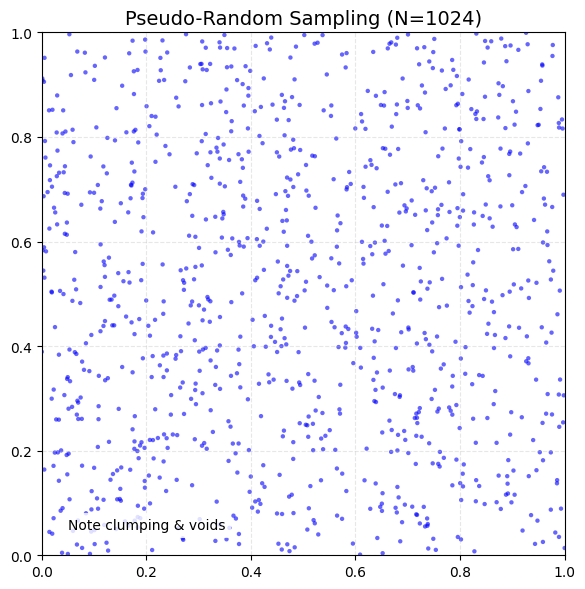

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_comparison(n_samples=1024, point_size=10):
    """
    Generates N pseudo-random 2D samples and plots them.
    Designed to compare against a Sobol sequence plot.
    """
    # 1. Generate pseudo-random points in [0, 1)^2
    pts_rand = np.random.rand(n_samples, 2)
    
    # 2. Setup the plot
    plt.figure(figsize=(6, 6))
    
    # 3. Create the Scatter Plot
    plt.scatter(pts_rand[:, 0], pts_rand[:, 1], 
                s=point_size,          # Size of dots
                c='blue',              # Color
                alpha=0.6,             # Transparency (helps see clumps)
                edgecolors='none')     # No borders for cleaner look
    
    # 4. Styling to match standard unit-square plots
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal')      # Ensure it looks like a square
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"Pseudo-Random Sampling (N={n_samples})", fontsize=14)
    
    # 5. Optional: Highlight a 'void' to prove the point
    # (Visually demonstrates why Random is bad for rendering)
    plt.text(0.05, 0.05, "Note clumping & voids", fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.tight_layout()
    plt.show()

# Run it
plot_random_comparison(1024)

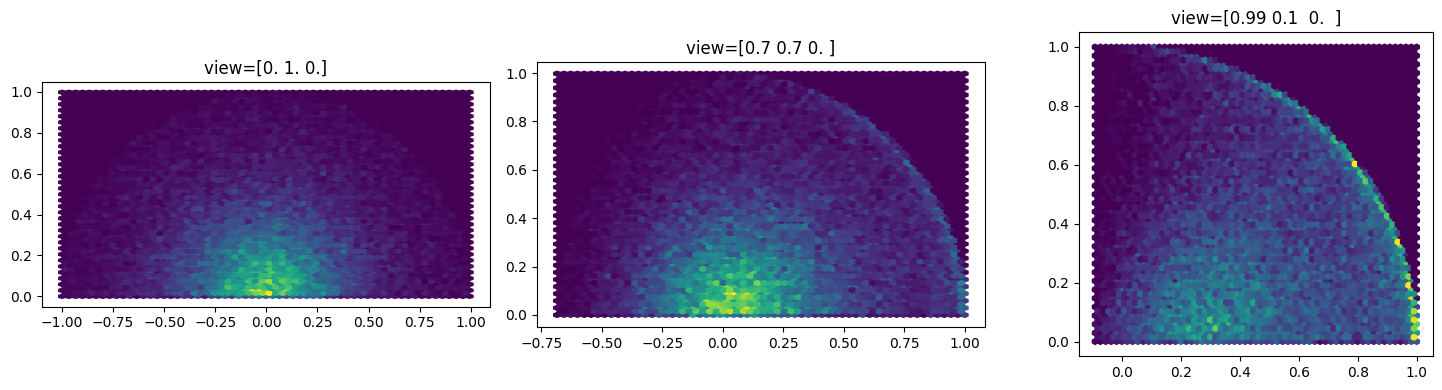

In [24]:
alph = 0.4
views = [
    np.array([0.0, 1.0, 0.0]),       # straight up
    np.array([0.7, 0.7, 0.0]),       # 45-degree
    np.array([0.99, 0.1, 0.0]),      # very grazing
]

plt.figure(figsize=(15,4))
for i, v in enumerate(views):
    H = sample_ggx_cloud(30000, v, alph, sampler="random")
    plt.subplot(1, len(views), i+1)
    plt.hexbin(H[:,0], H[:,2], gridsize=60)
    plt.title(f"view={np.round(v,2)}")
    plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()


In [25]:
# N = 2000
# view = np.array([0.0, 1.0, 0.0])
# alpha = 0.4

# H_rand = sample_ggx_cloud(N, view, alpha, sampler="random")

# sob = SobolInc(DIR_TABLE); sob.reset(0)
# H_sob  = sample_ggx_cloud(N, view, alpha, sampler="sobol", sobol=sob)

# sob = SobolInc(DIR_TABLE); sob.reset(0)
# H_owen = sample_ggx_cloud(N, view, alpha, sampler="sobol_owen",
#                           sobol=sob, owen_fn=owen_scramble_lk)

# plt.figure(figsize=(15,4))
# plt.subplot(1,3,1); plt.hexbin(H_rand[:,0], H_rand[:,2], gridsize=60); plt.title("Random")
# plt.subplot(1,3,2); plt.hexbin(H_sob[:,0],  H_sob[:,2],  gridsize=60); plt.title("Sobol")
# plt.subplot(1,3,3); plt.hexbin(H_owen[:,0], H_owen[:,2], gridsize=60); plt.title("Sobol+Owen")
# for ax in plt.gcf().axes: ax.set_aspect("equal")
# plt.tight_layout(); plt.show()
